In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import funm
import qutip.control.pulseoptim as cpo

We begin by saying that the smallest frequency solution to the 1D wave equation (i.e., Maxwell's equation) is
$$
    E(t,x) = \sin\left( \frac{\pi(2x + L)}{2L} \right) \cos\frac{c\pi t}{L}
$$
with the boundary condition $E(t,-L/2)=E(t,+L/2)=0$.

Consider two level system in a cavity with moving mirrors apart with velocity $v$. $L(t) = vt$. When we move mirrors we change the frequency of the cavity mode. So we can study the Jaynes-Cummings-like model (without using the rotating wave approximation)

$$
    \hat{H} = \frac{c\pi}{L_0 + L(t)}\hat{a}^{\dagger}\hat{a} + \omega_a\sigma_{-}^{\dagger} \sigma_{-}
        + g\left(\hat{a}^{\dagger} + \hat{a}\right)\left(\sigma_-^{\dagger} + \sigma_-\right)
$$

In [4]:
def compute_JC(L):
    """
    L is a function of time 
    """
    
    ##################################################
    #
    # Parameters
    #
    ##################################################
    N = 200
    
    c = 137
    omega_a = 0.1
    L0 = 1000.
    g = 0.1
    
    ##################################################
    
    a  = tensor(destroy(N), qeye(2))
    sigma_minus = tensor(qeye(N), destroy(2))
    n_cavity = a.dag() * a
    n_atom = sigma_minus.dag() * sigma_minus
    
    # get ground state at t = 0
    H0 = omega_a * n_atom + g * (a.dag() + a) * (sigma_minus.dag() + sigma_minus)
    H = c * np.pi / L0 * n_cavity + H0
    evals, ekets = H.eigenstates()
    ground_state = ekets[0]
    
    #print(max([expect(n_atom, ket) for ket in ekets]), [expect(n_atom, ket) for ket in ekets])
    #   print(expect(n_atom, ekets[1]))
    #print(expect(n_atom, ground_state))
    #print(expect(n_cavity, ground_state))

    
    #H = [H0, [n_cavity, lambda t, args: c * np.pi/ (L + v * t )]]
    # H = [H0, [n_cavity, lambda t, args: c * np.pi/ (L + np.exp(0.04 * t) )]]
    ########## H = [H0, [n_cavity, lambda t, args: c * np.pi/ (L + 2000 * (1 + np.sin(0.1 * t)) )]]
    H = [H0, [n_cavity, lambda t, args: c * np.pi/ (L0 + L(t))]]
    
    
    
    time = np.linspace(0., 400., 500)
    results = mesolve(H, ground_state, time, e_ops=[n_cavity, n_atom], options=Options(nsteps=2000))
    
    plot_expectation_values(
        results, 
        ylabels=['$\\langle \\hat{a}^{\\dagger}\\hat{a} \\rangle$', '$\\langle\\sigma_{-}^{\\dagger}\\sigma_{-}\\rangle$']
    )
    
    ##########
    
    ground_state_H0 = H0.eigenstates()[1][0]
    print(expect(n_atom, ground_state_H0))
    print(expect(n_cavity, ground_state_H0))
    
    """
    #################### Control ##################
    # Number of time slots
    n_ts = 5
    # Time allowed for the evolution
    evo_time = 30
    # Fidelity error target
    fid_err_targ = 1e-3
    # Maximum iterations for the optisation algorithm
    max_iter = 500
    # Maximum (elapsed) time allowed in seconds
    max_wall_time = 500
    #Set this to None or logging.WARN for 'quiet' execution
    import qutip.logging_utils as logging
    log_level = logging.INFO
    
    result = cpo.opt_pulse_crab_unitary(c * np.pi / L * n_cavity + H0, [n_cavity], ground_state, ekets[1], n_ts, evo_time, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                init_coeff_scaling=5.0, num_coeffs=5, 
                method_params={'xtol':1e-3},
                guess_pulse_type=None, guess_pulse_action='MODULATE',
                out_file_ext=None,
                log_level=log_level, gen_stats=True
                )
    return result
    """


0.49086070174229834
191.00219189787057


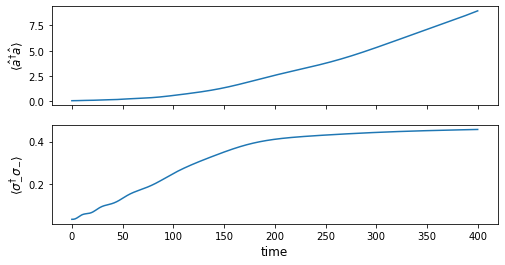

In [5]:
result = compute_JC(lambda t: 30. * t)

0.49086070174229834
191.00219189787057


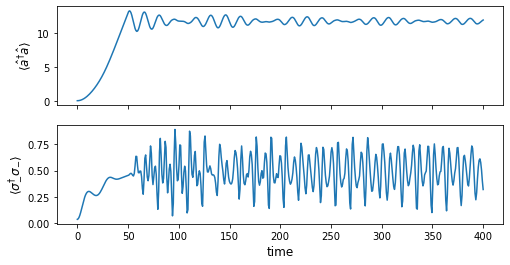

In [26]:
# if you allow for a discontinuous velocity, than we can populate the excited states much more significantly 
result = compute_JC(lambda t: 1e4 * (t < 50.))

0.49086070174229834
191.00219189787057


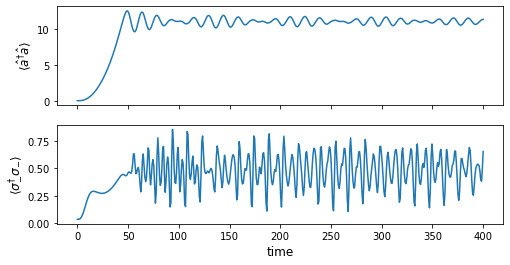

In [59]:
# L with larger than the speed of light L'
compute_JC(lambda t: 3e4 * np.sin(np.pi * t / 50) ** 2 * (t < 50.))

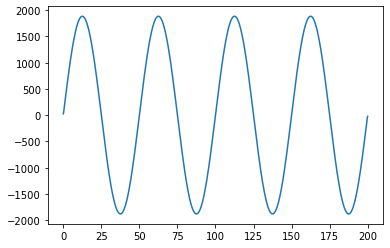

In [60]:
t = np.linspace(0, 200, 1000)
plt.plot(t, np.gradient(3e4 * np.sin(np.pi * t / 50) ** 2, t[1]-t[0]) )

In [ ]:
"""
result.stats.report()
# print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
# print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))
"""

In [ ]:
"""
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time, 
         np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])), 
         where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time, 
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])), 
         where='post')
plt.tight_layout()
plt.show()
"""

## Specifying quantum system

The hamiltonian
$$
    \hat{H} = \frac{1}{2}\hat{p}^2 + V(\hat{x}) + \frac{c\pi}{L} \hat{a}^{\dagger}\hat{a} 
        + g (\hat{a}^{\dagger}+ \hat{a}) \sin\left(\frac{\pi}{L}\left[\hat{x} - \frac{L}{2}\right]\right),
$$
with the potential energy as assymetric potential energy barrier
$$
    V(\hat{x}) = \alpha\hat{x}^4 - \beta\hat{x}^2 + \gamma\hat{x}
$$

In [ ]:
N = 80

a = destroy(N)

# momentum operator
p = 1j * np.sqrt(0.5 * 1.) * (a.dag() - a)

# coordinate operator
x = np.sqrt(0.5 / 1.) * (a.dag() + a)

In [ ]:
# potential energy
alpha = 1/300.
beta = 1/4.
gamma = -0.3

c = 137
L = 1000.
g = 0.2

V = lambda x: alpha * x ** 4 - beta * x ** 2 + gamma * x

In [ ]:
# plot the potential energy (in the coordinate representation)
x_grid = np.sort(x.eigenenergies()) 

plt.title("Potential energy $V(x)$")
plt.plot(x_grid, V(x_grid), '*-')
plt.xlabel("$x$ (a.u.)")
plt.ylabel("$V(x)$")
plt.xlim([-15, 15])
plt.ylim([-10, 10])

In [ ]:
# define the total hamiltonian
H_atom = tensor(qeye(N), 0.5 * p ** 2 + V(x))
H0 = H_atom + g * tensor(a.dag() + a, x)
n_cavity = tensor(a.dag() * a, qeye(N))

H = H0 + c * np.pi/ L * n_cavity

v = 10

In [ ]:
# the projector to the right hand side of x
proj_right_x = Qobj(funm(x.data.toarray(), lambda x: (x > 0)))
proj_right_x = tensor(qeye(N), proj_right_x)

In [ ]:
evals, ekets = H.eigenstates()
ground_state = ekets[0]
#ground_state = H.groundstate()

In [ ]:
H = [H0, [n_cavity, lambda t, args: c * np.pi/ (L + v * t )]]

In [ ]:
time = np.linspace(0., 600., 100)
results = mesolve(H, ground_state, time, e_ops=[n_cavity, proj_right_x])
    
plot_expectation_values(
    results, 
    ylabels=['$\\langle \hat{a}^{\dagger}\hat{a} \\rangle$', '$\\langle\sigma_{-}^{\dagger} \sigma_{-}\\rangle$']
)